# [Autoencoders](https://arxiv.org/abs/2201.03898)

## PS6 - Put your answers in these Markdown cells by editing them. You'll find the questions in various Markdown cells

When training CNNs, one of the problems is that we need a lot of labeled data. In the case of image classification, we need to separate images into different classes, which is a manual effort.

However, we might want to use raw (unlabeled) data for training CNN feature extractors, which is called **self-supervised learning**. Instead of labels, we will use training images as both network input and output. The main idea of **autoencoder** is that we will have an **encoder network** that converts input image into some **latent space** (normally it is just a vector of some smaller size), then the **decoder network**, whose goal would be to reconstruct the original image.

Since we are training autoencoder to capture as much of the information from the original image as possible for accurate reconstruction, the network tries to find the best **embedding** of input images to capture the meaning.

![AutoEncoder Diagram](images/autoencoder_schema.jpg)

> Image from [Keras blog](https://blog.keras.io/building-autoencoders-in-keras.html)

Let's create simplest autoencoder for MNIST!

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn
from torch import optim
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
torch.manual_seed(42)
np.random.seed(42)

/Users/admin/Library/Caches/pypoetry/virtualenvs/city-expression--rOxhvYN-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Define training parameters and check if the GPU is available:

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
train_size = 0.9
lr = 1e-3
eps = 1e-8
batch_size = 256
epochs = 30

The following function will load the MNIST dataset and apply specified transforms to it. It will also split it into train/test datasets.

In [3]:
def mnist(train_part, transform=None):
    dataset = torchvision.datasets.MNIST('.', download=True, transform=transform)
    train_part = int(train_part * len(dataset))
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_part, len(dataset) - train_part])
    return train_dataset, test_dataset

Now let's load the dataset and define dataloaders for train and test:

In [4]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset, test_dataset = mnist(train_size, transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, drop_last=True, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
dataloaders = (train_dataloader, test_dataloader)

In [5]:

def plotn(n, data, noisy=False, super_res=None):
    fig, ax = plt.subplots(1, n)
    for i, z in enumerate(data):
        if i == n:
            break
        preprocess = z[0].reshape(1, 28, 28) if z[0].shape[1] == 28 else z[0].reshape(1, 14, 14) if z[0].shape[1] == 14 else z[0]
        if super_res is not None:
            _transform = transforms.Resize((int(preprocess.shape[1] / super_res), int(preprocess.shape[2] / super_res)))
            preprocess = _transform(preprocess)

        if noisy:
            shapes = list(preprocess.shape)
            preprocess += noisify(shapes)

        ax[i].imshow(preprocess[0])
    plt.show()

In [6]:
def noisify(shapes):
    return np.random.normal(loc=0.5, scale=0.3, size=shapes)

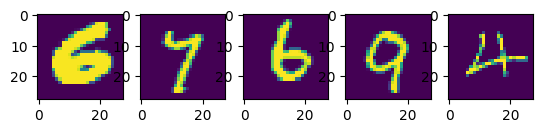

In [7]:
plotn(5, train_dataset)

## Use the Pytorch documentation and videos https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html to answer these questions

### What are the different "types" of layers being used in the Encoder below and say in words what they do?
The encoder compresses the input into a lower-dimensional code. The code consists of the innermost layer of the network and represents a compact “summary” or “compression” of the input, also called the latent-space representation.

### What are the arguments to Conv2d 
- `nn.Conv2d` this is a double convolutional layer which applies a 2D convolution over an input signal composed of several input planes. 
    - in_channels: this is the number in the input layer (often, if this is the image itself it is 256,256)
    - out_channels: the number of output chanels (which is K* input_channele where K is a positive integer, this operation is also known as a “depthwise convolution”)

### What does maxpool do?  
- `nn.MaxPool2d` Applies a 2D max pooling over an input signal composed of several input planes.

### What does ReLU do? 
- `nn.ReLU` Applies the rectified linear unit function element-wise


In [8]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), padding='same')
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(16, 8, kernel_size=(3, 3), padding='same')
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv3 = nn.Conv2d(8, 8, kernel_size=(3, 3), padding='same')
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2), padding=(1, 1))
        self.relu = nn.ReLU()

    def forward(self, input):
        hidden1 = self.maxpool1(self.relu(self.conv1(input)))
        hidden2 = self.maxpool2(self.relu(self.conv2(hidden1)))
        encoded = self.maxpool3(self.relu(self.conv3(hidden2)))
        return encoded

### What does upsample do? 

In [9]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(8, 8, kernel_size=(3, 3), padding='same')
        self.upsample1 = nn.Upsample(scale_factor=(2, 2))
        self.conv2 = nn.Conv2d(8, 8, kernel_size=(3, 3), padding='same')
        self.upsample2 = nn.Upsample(scale_factor=(2, 2))
        self.conv3 = nn.Conv2d(8, 16, kernel_size=(3, 3))
        self.upsample3 = nn.Upsample(scale_factor=(2, 2))
        self.conv4 = nn.Conv2d(16, 1, kernel_size=(3, 3), padding='same')
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        hidden1 = self.upsample1(self.relu(self.conv1(input)))
        hidden2 = self.upsample2(self.relu(self.conv2(hidden1)))
        hidden3 = self.upsample3(self.relu(self.conv3(hidden2)))
        decoded = self.sigmoid(self.conv4(hidden3))
        return decoded

In [10]:
class AutoEncoder(nn.Module):
    def __init__(self, super_resolution=False):
        super().__init__()
        if not super_resolution:
            self.encoder = Encoder()
        else:
            self.encoder = SuperResolutionEncoder()
        self.decoder = Decoder()

    def forward(self, input):
        encoded = self.encoder(input)
        decoded = self.decoder(encoded)
        return decoded

In [24]:
model = AutoEncoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, eps=eps)
loss_fn = nn.BCELoss()

### What does the optimizer do in the code below? 
- Optimization is a process where we try to find the best possible set of parameters for a deep learning model. Optimizers generate new parameter values and evaluate them using some criterion to determine the best option.
### Which optimizer is being used?
- Adam, an extension to stochastic gradient descent
Adam as combining the advantages of two other extensions of stochastic gradient descent. Specifically:

Adaptive Gradient Algorithm (AdaGrad) that maintains a per-parameter learning rate that improves performance on problems with sparse gradients (e.g. natural language and computer vision problems).
Root Mean Square Propagation (RMSProp) that also maintains per-parameter learning rates that are adapted based on the average of recent magnitudes of the gradients for the weight (e.g. how quickly it is changing). This means the algorithm does well on online and non-stationary problems (e.g. noisy).
Adam realizes the benefits of both AdaGrad and RMSProp.

In [15]:
def train(dataloaders, model, loss_fn, optimizer, epochs, device, noisy=None, super_res=None):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader, test_dataloader = dataloaders[0], dataloaders[1]

    for epoch in tqdm_iter:
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch in train_dataloader:
            imgs, labels = batch
            shapes = list(imgs.shape)

            if super_res is not None:
                shapes[2], shapes[3] = int(shapes[2] / super_res), int(shapes[3] / super_res)
                _transform = transforms.Resize((shapes[2], shapes[3]))
                imgs_transformed = _transform(imgs)
                imgs_transformed = imgs_transformed.to(device)

            imgs = imgs.to(device)
            labels = labels.to(device)

            if noisy is not None:
                noisy_tensor = noisy[0]
            else:
                noisy_tensor = torch.zeros(tuple(shapes)).to(device)

            if super_res is None:
                imgs_noisy = imgs + noisy_tensor
            else:
                imgs_noisy = imgs_transformed + noisy_tensor

            imgs_noisy = torch.clamp(imgs_noisy, 0., 1.)

            preds = model(imgs_noisy)
            loss = loss_fn(preds, imgs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for batch in test_dataloader:
                imgs, labels = batch
                shapes = list(imgs.shape)

                if super_res is not None:
                    shapes[2], shapes[3] = int(shapes[2] / super_res), int(shapes[3] / super_res)
                    _transform = transforms.Resize((shapes[2], shapes[3]))
                    imgs_transformed = _transform(imgs)
                    imgs_transformed = imgs_transformed.to(device)


                imgs = imgs.to(device)
                labels = labels.to(device)

                if noisy is not None:
                    test_noisy_tensor = noisy[1]
                else:
                    test_noisy_tensor = torch.zeros(tuple(shapes)).to(device)

                if super_res is None:
                    imgs_noisy = imgs + test_noisy_tensor
                else:
                    imgs_noisy = imgs_transformed + test_noisy_tensor

                imgs_noisy = torch.clamp(imgs_noisy, 0., 1.)

                preds = model(imgs_noisy)
                loss = loss_fn(preds, imgs)

                test_loss += loss.item()

        train_loss /= len(train_dataloader)
        test_loss /= len(test_dataloader)

        tqdm_dct = {'train loss:': train_loss, 'test loss:': test_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()

In [59]:
train(dataloaders, model, loss_fn, optimizer, epochs, device)

  0%|          | 0/30 [00:00<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

torch.Size([1, 16, 28, 28])
torch.Size([1, 16, 28, 28])
torch.Size([1, 16, 28, 28])
torch.Size([1, 16, 28, 28])
torch.Size([1, 16, 28, 28])
torch.Size([1, 16, 28, 28])
torch.Size([1, 16, 28, 28])
torch.Size([1, 16, 28, 28])
torch.Size([1, 16, 28, 28])
torch.Size([1, 16, 28, 28])


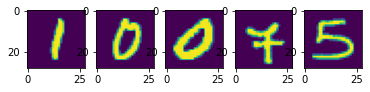

RuntimeError: shape '[1, 28, 28]' is invalid for input of size 12544

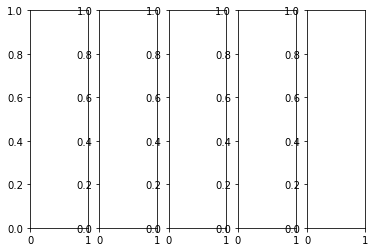

In [26]:
model.eval()
predictions = []
plots = 5
for i, data in enumerate(test_dataset):
    if i == plots:
        break
    predictions.append(model(data[0].to(device).unsqueeze(0)).detach().cpu())
plotn(plots, test_dataset)
plotn(plots, predictions)

> **Task 1**: Try to train autoencoder with very small latent vector size, eg. 2, and plot the dots corresponding to different digits. *Hint: Use fully-connected dense layer after the convoluitonal part to reduce the vector size to the required value.*


In this example, we'll create a convolutional autoencoder with a very small latent vector size (2 dimensions) and plot the resulting latent space representations for the MNIST dataset digits.

In [33]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 7*7*64),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

def train(model, dataloader, criterion, optimizer, device, epochs):
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        for batch_idx, (data, _) in enumerate(dataloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, _ = model(data)
            loss = criterion(recon_batch, data)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        print(f'Epoch: {epoch+1}, Loss: {train_loss / len(dataloader.dataset)}')

def plot_latent_space(model, dataloader, device):
    model.eval()
    zs, ys = [], []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            _, z = model(data)
            zs.append(z.cpu().numpy())
            ys.append(labels.numpy())
    zs, ys = np.concatenate(zs), np.concatenate(ys)
    plt.figure(figsize=(8, 6))
    for i in range(10):
        plt.scatter(zs[ys == i, 0], zs[ys == i, 1], label=f'{i}', alpha=0.5)
    plt.legend()
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('MNIST Latent Space Visualization')
    plt.show()

Epoch: 1, Loss: 0.06749759800086419
Epoch: 2, Loss: 0.06400413130074739
Epoch: 3, Loss: 0.06333371492524942
Epoch: 4, Loss: 0.0629329982717832
Epoch: 5, Loss: 0.06268693440804879
Epoch: 6, Loss: 0.06247094924102227
Epoch: 7, Loss: 0.06230490662058195
Epoch: 8, Loss: 0.06217220241377751
Epoch: 9, Loss: 0.06207295736918847
Epoch: 10, Loss: 0.0619844998622934


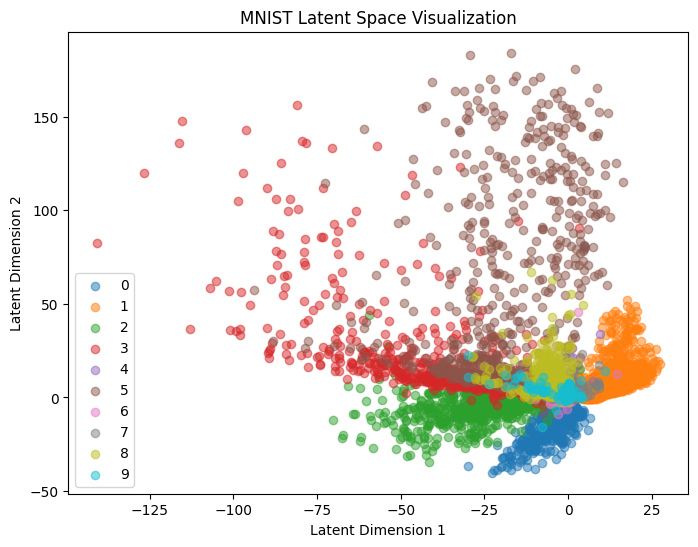

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 10
epochs = 10

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

mnist_test = datasets.MNIST('./data', train=False, download=True, transform=transform)
test_loader =DataLoader(mnist_test, batch_size=batch_size, shuffle=True)
model = ConvAutoencoder().to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train the model
train(model, train_loader, criterion, optimizer, device, epochs)

# Plot the latent space
plot_latent_space(model, test_loader, device)

> **Task 2**: Starting from different digits, obtain their latent space representations, and see what effect adding some noise to the latent space has on the resulting digits.

### Task 2
To explore the effect of adding noise to the latent space representations of digits in the MNIST dataset, we can follow these steps:

Load the MNIST dataset
- Create a Variational Autoencoder (VAE) model
- Train the VAE on the MNIST dataset
- Encode the digits into the latent space
- Add noise to the latent space representations
- Decode the noisy latent representations back to the image space
- Visualize the results


Epoch: 1 - Loss: 181.0569
Epoch: 2 - Loss: 161.2096
Epoch: 3 - Loss: 156.2341
Epoch: 4 - Loss: 153.6480
Epoch: 5 - Loss: 151.9836
Epoch: 6 - Loss: 150.6352
Epoch: 7 - Loss: 149.4734
Epoch: 8 - Loss: 148.5254
Epoch: 9 - Loss: 147.6246
Epoch: 10 - Loss: 146.8598


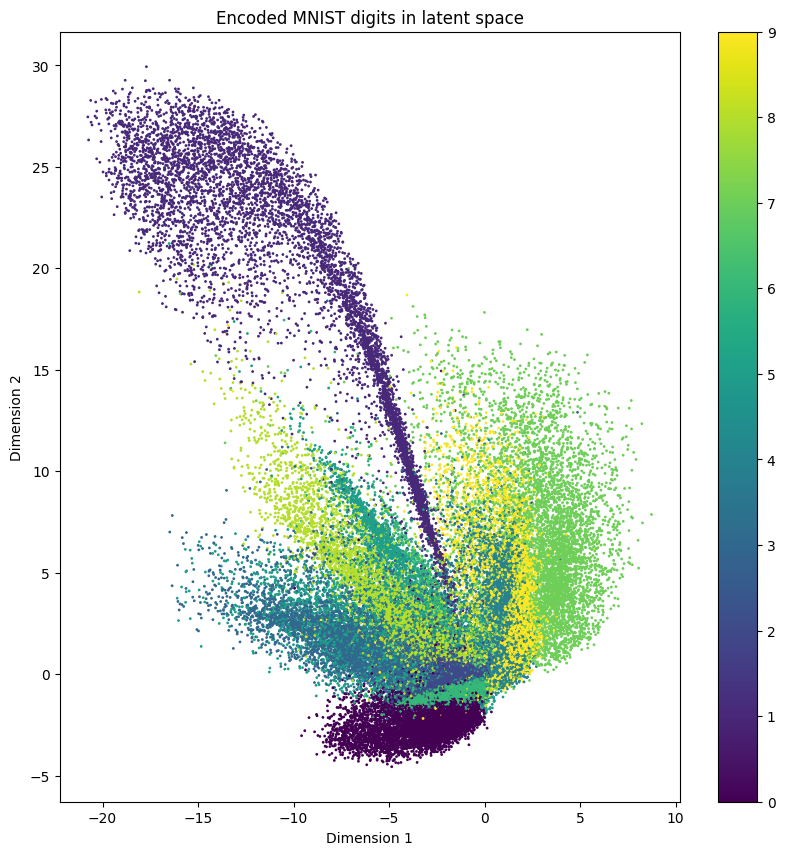

In [36]:
# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z), z

def loss_function(recon_x, x):
    return nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

# Initialize the Autoencoder and optimizer
input_dim = 28 * 28
hidden_dim = 400
latent_dim = 2
model = Autoencoder(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train the Autoencoder
epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, _ = model(data)
        loss = loss_function(recon_batch, data)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print('Epoch: {} - Loss: {:.4f}'.format(epoch + 1, train_loss / len(train_loader.dataset)))

# Visualize the encoded latent space
with torch.no_grad():
    model.eval()
    encoded_points = []
    labels = []
    for data, target in train_loader:
        _, z = model(data)
        encoded_points.append(z)
        labels.append(target)
        
    encoded_points = torch.cat(encoded_points, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()

plt.figure(figsize=(10, 10))
scatter = plt.scatter(encoded_points[:, 0], encoded_points[:, 1], c=labels, cmap='viridis', s=1)
plt.colorbar(scatter)
plt.title("Encoded MNIST digits in latent space")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

To see the effect of adding noise to the latent space, you can generate a grid of points in the latent space, add some noise, and then visualize the decoded digits.

Here's the modified code to add noise to the latent space and visualize the results:

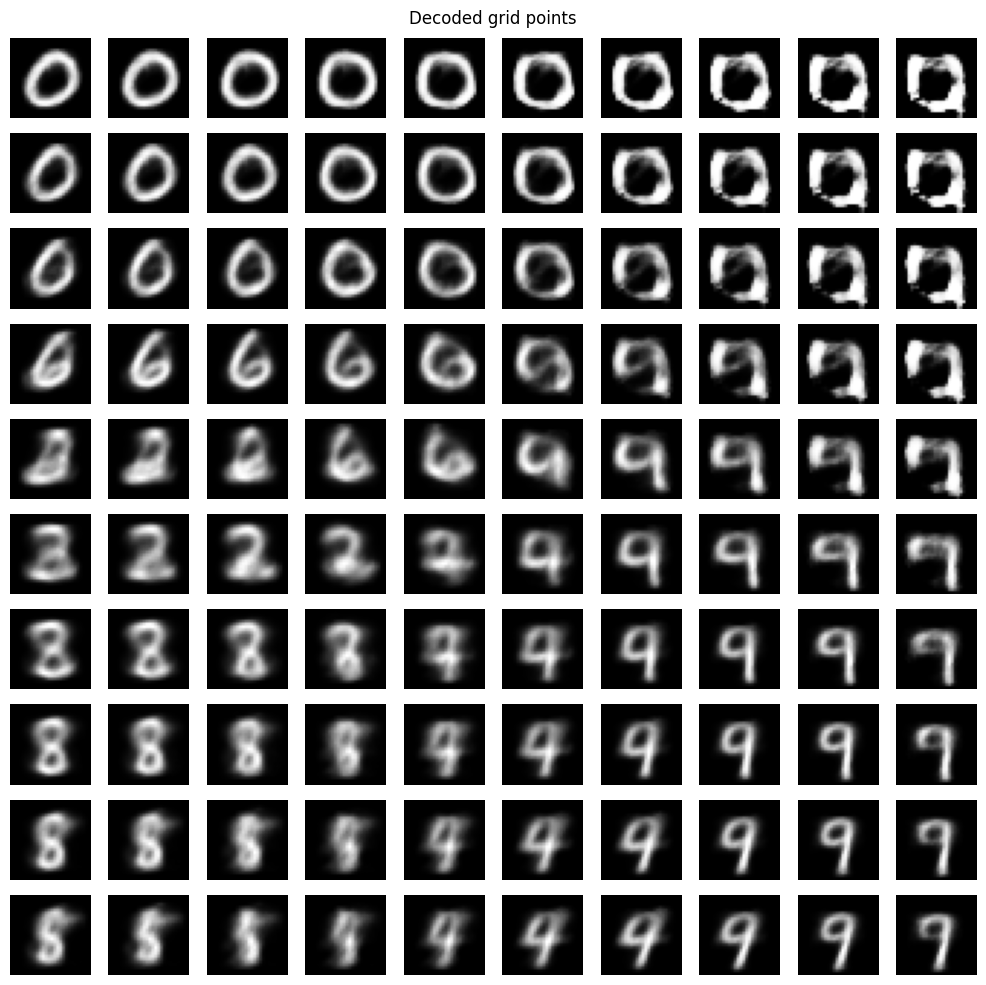

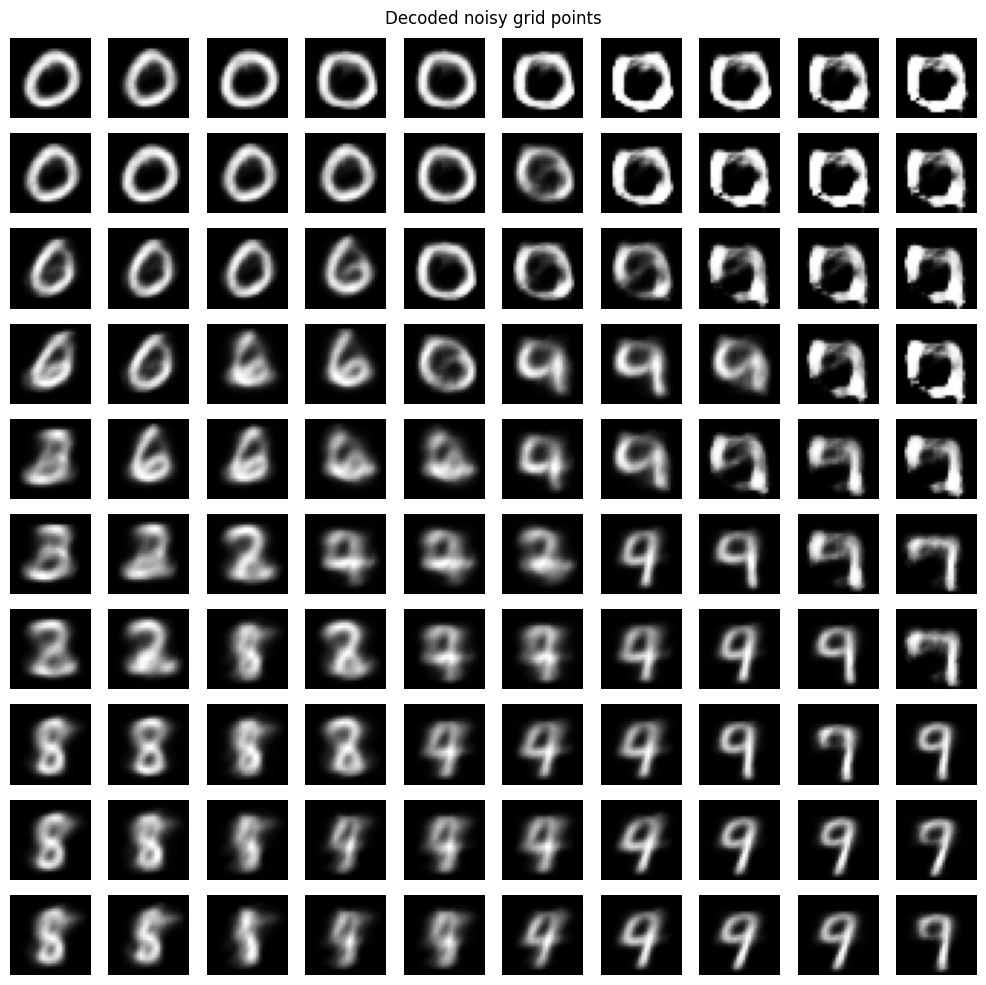

In [37]:
def plot_digits(decoded_digits, title):
    fig, axes = plt.subplots(10, 10, figsize=(10, 10), sharex=True, sharey=True)
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(decoded_digits[i], cmap='gray')
        ax.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Generate a grid of points in the latent space
x = np.linspace(-3, 3, 10)
y = np.linspace(-3, 3, 10)
grid_x, grid_y = np.meshgrid(x, y)
grid_points = np.column_stack((grid_x.flatten(), grid_y.flatten()))

# Add noise to the grid points
noise_std = 0.5
noise = np.random.normal(0, noise_std, grid_points.shape)
noisy_grid_points = grid_points + noise

# Decode the grid points and the noisy grid points
with torch.no_grad():
    model.eval()
    decoded_grid_points = model.decoder(torch.tensor(grid_points, dtype=torch.float32)).view(-1, 28, 28).cpu().numpy()
    decoded_noisy_grid_points = model.decoder(torch.tensor(noisy_grid_points, dtype=torch.float32)).view(-1, 28, 28).cpu().numpy()

# Plot the decoded digits
plot_digits(decoded_grid_points, 'Decoded grid points')
plot_digits(decoded_noisy_grid_points, 'Decoded noisy grid points')

## Denoising

Autoencoders can be effectively used to remove noise from images. In order to train denoiser, we will start with noise-free images, and add artificial noise to them. Then, we will feed autoencoder with noisy images as input, and noise-free images as output.

Let's see how this works for MNIST:

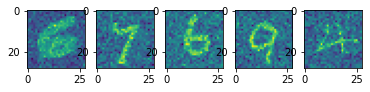

In [72]:
plotn(5, train_dataset, noisy=True)

In [73]:
model = AutoEncoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, eps=eps)
loss_fn = nn.BCELoss()

In [74]:
noisy_tensor = torch.FloatTensor(noisify([256, 1, 28, 28])).to(device)
test_noisy_tensor = torch.FloatTensor(noisify([1, 1, 28, 28])).to(device)
noisy_tensors = (noisy_tensor, test_noisy_tensor)

In [75]:
train(dataloaders, model, loss_fn, optimizer, 100, device, noisy=noisy_tensors)

  1%|          | 1/100 [00:15<25:32, 15.48s/it, train loss:=0.354, test loss:=0.262]


KeyboardInterrupt: 

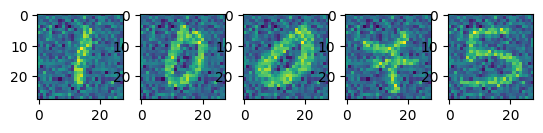

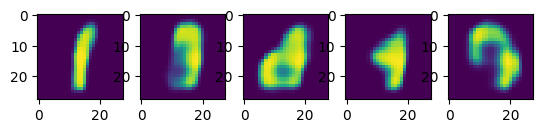

In [24]:
model.eval()
predictions = []
noise = []
plots = 5
for i, data in enumerate(test_dataset):
    if i == plots:
        break
    shapes = data[0].shape
    noisy_data = data[0] + test_noisy_tensor[0].detach().cpu()
    noise.append(noisy_data)
    predictions.append(model(noisy_data.to(device).unsqueeze(0)).detach().cpu())
plotn(plots, noise)
plotn(plots, predictions)

> **Exercise:** See how denoiser trained on MNIST digits works for different images. As an example, you can take [Fashion MNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST) dataset, which has the same image size. Note that denoiser works well only on the same image type that it was trained on (i.e. for the same probability distribution of input data).

To demonstrate how a denoiser trained on MNIST digits performs on different images, we will use the Fashion MNIST dataset. First, we'll train the denoising autoencoder on the MNIST dataset, and then we'll test it on the Fashion MNIST dataset to see its performance.

In [38]:
from torchvision import datasets

class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

def train_denoiser(model, dataloader, criterion, optimizer, device, epochs, noise_factor):
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        for batch_idx, (data, _) in enumerate(dataloader):
            data = data.to(device).view(-1, 28 * 28)
            noisy_data = data + noise_factor * torch.randn_like(data)
            noisy_data = torch.clamp(noisy_data, 0., 1.)
            optimizer.zero_grad()
            recon_data = model(noisy_data)
            loss = criterion(recon_data, data)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        print(f'Epoch: {epoch+1}, Loss: {train_loss / len(dataloader.dataset)}')

def test_denoiser(model, dataloader, device, noise_factor):
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(dataloader):
            data = data.to(device).view(-1, 28 * 28)
            noisy_data = data + noise_factor * torch.randn_like(data)
            noisy_data = torch.clamp(noisy_data, 0., 1.)
            recon_data = model(noisy_data)

            if batch_idx == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data.view(-1, 1, 28, 28)[:n],
                                        noisy_data.view(-1, 1, 28, 28)[:n],
                                        recon_data.view(-1, 1, 28, 28)[:n]])
                torchvision.utils.save_image(comparison.cpu(),
                                             'denoising_results_fashion_mnist.png',
                                             nrow=n)
                break

In [40]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DenoisingAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
batch_size = 128
epochs = 10
noise_factor = 0.5

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Setup training data
train_data = datasets.FashionMNIST(root="data", train=True,download=True, transform=transforms.ToTensor(), target_transform=None # you can transform labels as well
)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)


# Setup testing data
test_data = datasets.FashionMNIST(root="data",train=False, download=True,transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=128, shuffle=True)

train_denoiser(model, train_loader, criterion, optimizer, device, epochs, noise_factor)

# Test the model and save the results
test_denoiser(model, test_loader, device, noise_factor)


Epoch: 1, Loss: 0.00042284538003926474
Epoch: 2, Loss: 0.00022554396263634166
Epoch: 3, Loss: 0.00019828871494779985
Epoch: 4, Loss: 0.00018974506873637437
Epoch: 5, Loss: 0.00018332642757644255
Epoch: 6, Loss: 0.00017812063066909711
Epoch: 7, Loss: 0.00017270929512257376
Epoch: 8, Loss: 0.0001688834944119056
Epoch: 9, Loss: 0.00016526716832692423
Epoch: 10, Loss: 0.00016251722769811748


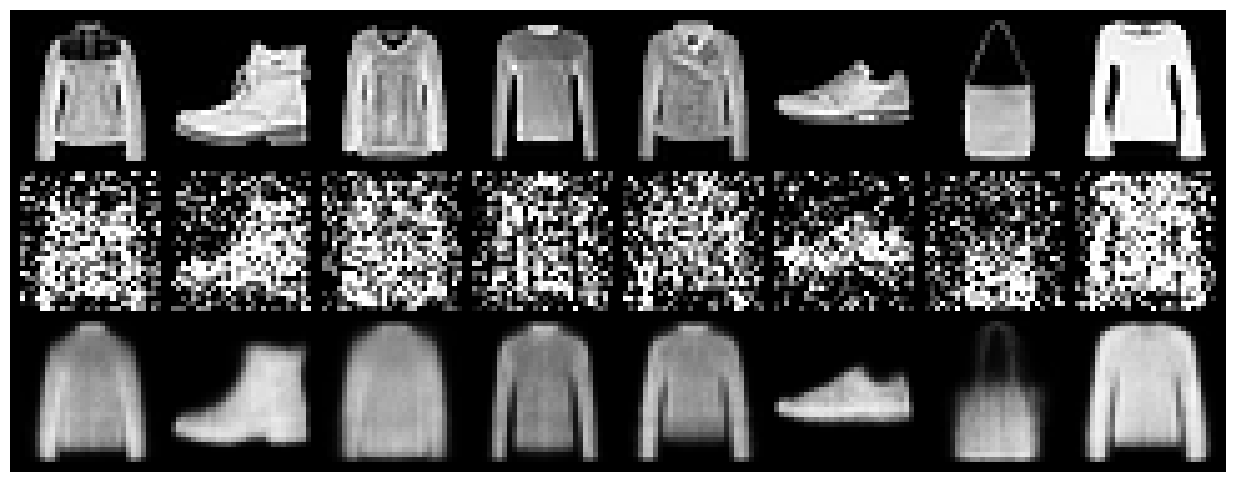

In [41]:
import matplotlib.image as mpimg

# Load and display the saved image
comparison_image = mpimg.imread('denoising_results_fashion_mnist.png')
plt.figure(figsize=(18, 6))
plt.imshow(comparison_image, cmap='gray')
plt.axis('off')
plt.show()

## Super-Resolution

Similarly to denoiser, we can train autoencoders to increase the resolution of the image. To train super-resolution network, we will start with high-resolution images, and automatically downscale them to produce network inputs. We will then feed autoencoder with small images as inputs and high-resolution images as outputs.

For that let's downscale image to 14x14 at train.

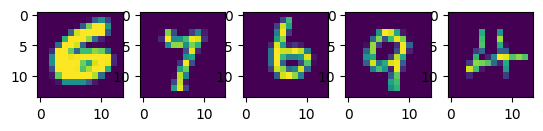

In [25]:
super_res_koeff = 2.0
plotn(5, train_dataset, super_res=super_res_koeff)

In [42]:
class SuperResolutionEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), padding='same')
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(16, 8, kernel_size=(3, 3), padding='same')
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), padding=(1, 1))
        self.relu = nn.ReLU()

    def forward(self, input):
        hidden1 = self.maxpool1(self.relu(self.conv1(input)))
        encoded = self.maxpool2(self.relu(self.conv2(hidden1)))
        return encoded

In [43]:
model = AutoEncoder(super_resolution=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, eps=eps)
loss_fn = nn.BCELoss()

In [205]:
train(dataloaders, model, loss_fn, optimizer, epochs, device, super_res=2.0)

100%|██████████| 30/30 [06:43<00:00, 13.47s/it, train loss:=0.102, test loss:=0.103]


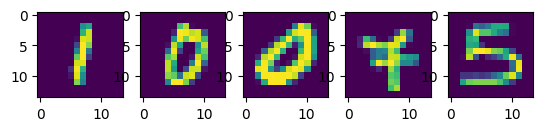

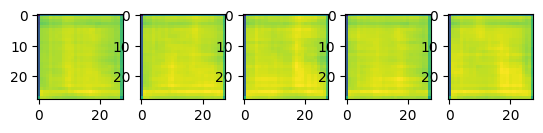

In [28]:
model.eval()
predictions = []
plots = 5
shapes = test_dataset[0][0].shape

for i, data in enumerate(test_dataset):
    if i == plots:
        break
    _transform = transforms.Resize((int(shapes[1] / super_res_koeff), int(shapes[2] / super_res_koeff)))
    predictions.append(model(_transform(data[0]).to(device).unsqueeze(0)).detach().cpu())
plotn(plots, test_dataset, super_res=super_res_koeff)
plotn(plots, predictions)

> **Exercise**: Try to train super-resolution network on [CIFAR-10](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html) for 2x and 4x upscaling. Use noise as input to 4x upscaling model and observe the result.

Training the Super Resolution Network using the CIFAR-10 dataset and upscale images by 2x and 4x.

In [44]:

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((16, 16)),
    transforms.ToTensor()
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:21<00:00, 7976941.46it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [59]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AutoEncoder(super_resolution=True).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [60]:
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, _ = data
        inputs = inputs.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, running_loss / (i + 1)))

Epoch [1/10], Loss: 0.0218
Epoch [2/10], Loss: 0.0137
Epoch [3/10], Loss: 0.0121
Epoch [4/10], Loss: 0.0111
Epoch [5/10], Loss: 0.0105
Epoch [6/10], Loss: 0.0100
Epoch [7/10], Loss: 0.0096
Epoch [8/10], Loss: 0.0093
Epoch [9/10], Loss: 0.0091
Epoch [10/10], Loss: 0.0089


To test the 2x upscaling, we can adjust the forward method of the Decoder class as follows:

To test the 4x upscaling with noise as input, modify the forward function again:

In [58]:
class SuperResolutionEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), padding='same')
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(16, 16, kernel_size=(3, 3), padding='same')
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv3 = nn.Conv2d(16, 8, kernel_size=(3, 3), padding='same')
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2))  # Removed padding
        self.relu = nn.ReLU()

    def forward(self, input):
        hidden1 = self.maxpool1(self.relu(self.conv1(input)))
        hidden2 = self.maxpool2(self.relu(self.conv2(hidden1)))
        encoded = self.maxpool3(self.relu(self.conv3(hidden2)))
        return encoded

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(8, 8, kernel_size=(3, 3), padding='same')
        self.upsample1 = nn.Upsample(scale_factor=(2, 2))
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), padding='same')
        self.upsample2 = nn.Upsample(scale_factor=(2, 2))
        self.conv3 = nn.Conv2d(16, 16, kernel_size=(3, 3), padding=1)  # Adjusted padding
        self.upsample3 = nn.Upsample(scale_factor=(2, 2))
        self.conv4 = nn.Conv2d(16, 1, kernel_size=(3, 3), padding='same')

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        hidden1 = self.upsample1(self.relu(self.conv1(input)))
        hidden2 = self.upsample2(self.relu(self.conv2(hidden1)))
        hidden3 = self.upsample3(self.relu(self.conv3(hidden2)))
        decoded = self.sigmoid(self.conv4(hidden3))
        return decoded

Create a noisy input and feed it to the model:

In [61]:
noise = torch.tensor(np.random.normal(0, 0.5, (1, 8, 4, 4)), dtype=torch.float32).to(device)
output = model.decoder(noise)

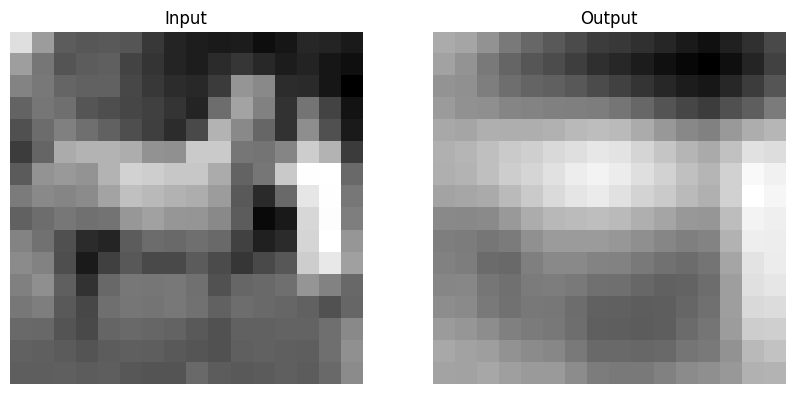

In [ ]:

# Function to plot the images
def plot_images(input_image, output_image, ground_truth=None):
    fig, axes = plt.subplots(1, 3 if ground_truth is not None else 2, figsize=(10, 5))

    axes[0].imshow(input_image.squeeze(), cmap='gray')
    axes[0].set_title('Input')
    axes[0].axis('off')

    axes[1].imshow(output_image.squeeze(), cmap='gray')
    axes[1].set_title('Output')
    axes[1].axis('off')

    if ground_truth is not None:
        axes[2].imshow(ground_truth.squeeze(), cmap='gray')
        axes[2].set_title('Ground Truth')
        axes[2].axis('off')

    plt.show()

# Select a sample from the dataset
sample_input, _ = next(iter(trainloader))

# Move the input to the device and pass it through the model
sample_input = sample_input.to(device)
sample_output = model(sample_input)

# Move the input and output back to the CPU and detach them from the computation graph
sample_input = sample_input.cpu().detach().numpy()
sample_output = sample_output.cpu().detach().numpy()

# Plot the input and output images
plot_images(noise, sample_output[10])  # Replace 0 with the desired index of the batch


# [Variational Auto-Encoders (VAE)](https://arxiv.org/abs/1906.02691)

Traditional autoencoders reduce the dimension of the input data somehow, figuring out the important features of input images. However, latent vectors often do not make much sense. In other words, taking MNIST dataset as an example, figuring out which digits correspond to different latent vectors is not an easy task, because close latent vectors would not necessarily correspond to the same digits. 

On the other hand, to train *generative* models it is better to have some understanding of the latent space. This idea leads us to **variational auto-encoder** (VAE).

VAE is the autoencoder that learns to predict *statistical distribution* of the latent parameters, so-called **latent distribution**. For example, we can assume that latent vectors would be distributed as $N(\mathrm{z\_mean},e^{\mathrm{z\_log}})$, where $\mathrm{z\_mean}, \mathrm{z\_log} \in\mathbb{R}^d$. Encoder in VAE learns to predict those parameters, and then decoder takes a random vector from this distribution to reconstruct the object.

To summarize:

 * From input vector, we predict `z_mean` and `z_log` (instead of predicting the standard deviation itself, we predict it's logarithm)
 * We sample a vector `sample(z_val in code)` from the distribution $N(\mathrm{z\_mean},e^{\mathrm{z\_log\_sigma}})$
 * Decoder tries to decode the original image using `sample` as an input vector

 <img src="images/vae.png" width="50%">

 > Image from [this blog post](https://ijdykeman.github.io/ml/2016/12/21/cvae.html) by Isaak Dykeman

In [65]:
class VAEEncoder(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.intermediate_dim = 512
        self.latent_dim = 2
        self.linear = nn.Linear(784, self.intermediate_dim)
        self.z_mean = nn.Linear(self.intermediate_dim, self.latent_dim)
        self.z_log = nn.Linear(self.intermediate_dim, self.latent_dim)
        self.relu = nn.ReLU()
        self.device = device

    def forward(self, input):
        bs = input.shape[0]

        hidden = self.relu(self.linear(input))
        z_mean = self.z_mean(hidden)
        z_log = self.z_log(hidden)

        eps = torch.FloatTensor(np.random.normal(size=(bs, self.latent_dim))).to(device)
        z_val = z_mean + torch.exp(z_log) * eps
        return z_mean, z_log, z_val

In [66]:
class VAEDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.intermediate_dim = 512
        self.latent_dim = 2
        self.linear = nn.Linear(self.latent_dim, self.intermediate_dim)
        self.output = nn.Linear(self.intermediate_dim, 784)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        hidden = self.relu(self.linear(input))
        decoded = self.sigmoid(self.output(hidden))
        return decoded

In [122]:
class VAEAutoEncoder(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.encoder = VAEEncoder(device)
        self.decoder = VAEDecoder()
        self.z_vals = None

    def forward(self, input):
        bs, c, h, w = input.shape[0], input.shape[1], input.shape[2], input.shape[3]
        input = input.view(bs, -1)
        encoded = self.encoder(input)
        self.z_vals = encoded
        decoded = self.decoder(encoded[2])
        return decoded
    
    def get_zvals(self):
        return self.z_vals

Variational auto-encoders use complex loss function that consists of two parts:
* **Reconstruction loss** is the loss function that shows how close reconstructed image is to the target (can be MSE). It is the same loss function as in normal autoencoders.
* **KL loss**, which ensures that latent variable distributions stays close to normal distribution. It is based on the notion of [Kullback-Leibler divergence](https://www.countbayesie.com/blog/2017/5/9/kullback-leibler-divergence-explained) - a metric to estimate how similar two statistical distributions are.

In [123]:
def vae_loss(preds, targets, z_vals):
    mse = nn.MSELoss()
    reconstruction_loss = mse(preds, targets.view(targets.shape[0], -1)) * 784.0
    temp = 1.0 + z_vals[1] - torch.square(z_vals[0]) - torch.exp(z_vals[1])
    kl_loss = -0.5 * torch.sum(temp, axis=-1)
    return torch.mean(reconstruction_loss + kl_loss)

In [124]:
model = VAEAutoEncoder(device).to(device)
optimizer = optim.RMSprop(model.parameters(), lr=lr, eps=eps)

In [125]:
def train_vae(dataloaders, model, optimizer, epochs, device):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader, test_dataloader = dataloaders[0], dataloaders[1]

    for epoch in tqdm_iter:
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch in train_dataloader:
            imgs, labels = batch
            imgs = imgs.to(device)
            labels = labels.to(device)

            preds = model(imgs)
            z_vals = model.get_zvals()
            loss = vae_loss(preds, imgs, z_vals)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for batch in test_dataloader:
                imgs, labels = batch
                imgs = imgs.to(device)
                labels = labels.to(device)

                preds = model(imgs)
                z_vals = model.get_zvals()
                loss = vae_loss(preds, imgs, z_vals)

                test_loss += loss.item()

        train_loss /= len(train_dataloader)
        test_loss /= len(test_dataloader)

        tqdm_dct = {'train loss:': train_loss, 'test loss:': test_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()

In [71]:
train_vae(dataloaders, model, optimizer, epochs, device)

100%|██████████| 10/10 [02:26<00:00, 14.64s/it, train loss:=37.2, test loss:=37.2]


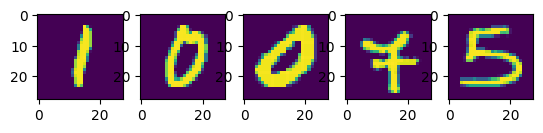

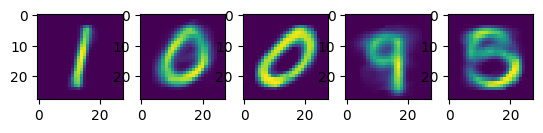

In [72]:
model.eval()
predictions = []
plots = 5
for i, data in enumerate(test_dataset):
    if i == plots:
        break
    predictions.append(model(data[0].to(device).unsqueeze(0)).view(1, 28, 28).detach().cpu())
plotn(plots, test_dataset)
plotn(plots, predictions)

> **Task**: In our sample, we have trained fully-connected VAE. Now take the CNN from traditional auto-encoder above and create CNN-based VAE.

To create a CNN-based VAE, we need to modify the VAEEncoder and VAEDecoder classes to use convolutional layers instead of linear layers. Here's an example of how we can create a CNN-based VAE using the CNN from the traditional autoencoder:



In [121]:
class VAEEncoder(nn.Module):
    def __init__(self, device, input_shape=(1, 28, 28)):
        super().__init__()
        self.device = device
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)

        out_dim1 = (input_shape[1] - 1) // 2 + 1
        out_dim2 = (input_shape[2] - 1) // 2 + 1
        out_dim1 = (out_dim1 - 1) // 2 + 1
        out_dim2 = (out_dim2 - 1) // 2 + 1
        self.flat_size = 32 * out_dim1 * out_dim2

        self.fc_mean = nn.Linear(self.flat_size, 2)
        self.fc_logvar = nn.Linear(self.flat_size, 2)
        self.relu = nn.ReLU()

    def forward(self, input):
        bs = input.shape[0]
        x = self.relu(self.conv1(input))
        x = self.relu(self.conv2(x))
        x = x.view(bs, -1)
        z_mean = self.fc_mean(x)
        z_logvar = self.fc_logvar(x)
        return z_mean, z_logvar

class VAEDecoder(nn.Module):
    def __init__(self, input_shape=(1, 28, 28)):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)

        out_dim1 = (input_shape[1] - 1) // 2 + 1
        out_dim2 = (input_shape[2] - 1) // 2 + 1
        out_dim1 = (out_dim1 - 1) // 2 + 1
        out_dim2 = (out_dim2 - 1) // 2 + 1
        self.flat_size = 32 * out_dim1 * out_dim2

        self.fc = nn.Linear(2, self.flat_size)
        self.deconv1 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        bs = input.shape[0]
        x = self.relu(self.fc(input))
        x = x.view(bs, 32, 7, 7)
        x = self.relu(self.deconv1(x))
        x = self.sigmoid(self.deconv2(x))
        return x

In [135]:
class VAEEncoder(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.fc_mu = nn.Linear(64 * 7 * 7, 8)
        self.fc_logvar = nn.Linear(64 * 7 * 7, 8)
        self.relu = nn.ReLU()
        self.device = device

    def forward(self, input):
        bs = input.shape[0]

        x = self.relu(self.conv1(input))
        x = self.relu(self.conv2(x))
        x = x.view(bs, -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std).to(self.device)
        z = eps * std + mu
        return mu, logvar, z

class VAEDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.latent_dim = 8
        self.fc = nn.Linear(self.latent_dim, 128 * 7 * 7)
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        x = self.relu(self.fc(z))
        x = x.view(x.size(0), 128, 7, 7)  # Reshape the tensor correctly
        x = self.relu(self.deconv1(x))
        x = self.sigmoid(self.deconv2(x))
        return x

This updated code creates a CNN-based VAE with a convolutional encoder and a transposed convolutional decoder. The encoder and decoder architecture is similar to the one used in the traditional autoencoder above, but the latent space is now represented by z_mean and z_log_var.

Now, the VAEEncoder class has two convolutional layers, and the VAEDecoder class has two transposed convolutional layers. This will create a CNN-based VAE. Note that we may need to adjust the layer sizes depending on out input image dimensions.

We can keep the VAEAutoEncoder class and the training loop the same as before.

In [142]:
class VAEAutoEncoder(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.encoder = VAEEncoder(device)
        self.decoder = VAEDecoder()
        self.z_vals = None

    def forward(self, input):
        bs = input.shape[0]

        z_mean, z_logvar, z = self.encoder(input)
        self.z_vals = (z_mean, z_logvar)
        
        # Sample z from the Gaussian distribution
        std = torch.exp(0.5 * z_logvar)
        eps = torch.randn_like(std).to(device)
        z = eps * std + z_mean

        decoded = self.decoder(z)
        return decoded

    def get_zvals(self):
        return self.z_vals

In [143]:
model = VAEAutoEncoder(device).to(device)
optimizer = optim.RMSprop(model.parameters(), lr=lr, eps=eps)

In [145]:
def vae_loss(preds, targets, z_vals):
    mse = nn.MSELoss()
    reconstruction_loss = mse(preds, targets) * 784.0
    temp = 1.0 + z_vals[1] - torch.square(z_vals[0]) - torch.exp(z_vals[1])
    kl_loss = -0.5 * torch.sum(temp, axis=-1)
    return torch.mean(reconstruction_loss + kl_loss)

In [146]:
train_vae(dataloaders, model, optimizer, epochs, device)

  0%|          | 0/10 [00:00<?, ?it/s]

In [120]:
# Initialize the VAEAutoEncoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae_model = VAEAutoEncoder(device).to(device)

train_vae(dataloaders, vae_model, optimizer, epochs, device)
# Function to plot the images
def plot_images(input_image, output_image, ground_truth=None):
    fig, axes = plt.subplots(1, 3 if ground_truth is not None else 2, figsize=(10, 5))

    axes[0].imshow(input_image.squeeze(), cmap='gray')
    axes[0].set_title('Input')
    axes[0].axis('off')

    axes[1].imshow(output_image.squeeze(), cmap='gray')
    axes[1].set_title('Output')
    axes[1].axis('off')

    if ground_truth is not None:
        axes[2].imshow(ground_truth.squeeze(), cmap='gray')
        axes[2].set_title('Ground Truth')
        axes[2].axis('off')

    plt.show()

# Select a sample from the dataset
sample_input, _ = next(iter(trainloader))

# Move the input to the device and pass it through the model
sample_input = sample_input.to(device)
sample_output = vae_model(sample_input)

# Move the input and output back to the CPU and detach them from the computation graph
sample_input = sample_input.cpu().detach().numpy()
sample_output = sample_output.cpu().detach().numpy()

# Plot the input and output images
plot_images(sample_input[0], sample_output[0])  # Replace 0 with the desired index of the batch


  0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: shape '[256, 32, 7, 7]' is invalid for input of size 1605632

# [Adversarial Auto-Encoders (AAE)](https://arxiv.org/abs/1511.05644)

Adversarial Auto-Encoders is a **combination** of Generative Adversarial Networks and Variational Auto-Encoders. 

Encoder will be the generator, discriminator will learn to distinguish the real images encoder output from generated ones. Encoder output is a distribution, from this output decoder will try decode image.

In this approach we have **three loss functions**: generator loss, discriminator loss from GAN's and reconstruction loss from VAE.

 <img src="images/aae.png" width="50%">

 > Image from [this blog post](https://blog.paperspace.com/adversarial-autoencoders-with-pytorch/) by Felipe Ducau

In [87]:
class AAEEncoder(nn.Module):
    def __init__(self, input_dim, inter_dim, latent_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, inter_dim)
        self.linear2 = nn.Linear(inter_dim, inter_dim)
        self.linear3 = nn.Linear(inter_dim, inter_dim)
        self.linear4 = nn.Linear(inter_dim, latent_dim)
        self.relu = nn.ReLU()
        
    def forward(self, input):
        hidden1 = self.relu(self.linear1(input))
        hidden2 = self.relu(self.linear2(hidden1))
        hidden3 = self.relu(self.linear3(hidden2))
        encoded = self.linear4(hidden3)
        return encoded

In [88]:
class AAEDecoder(nn.Module):
    def __init__(self, latent_dim, inter_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(latent_dim, inter_dim)
        self.linear2 = nn.Linear(inter_dim, inter_dim)
        self.linear3 = nn.Linear(inter_dim, inter_dim)
        self.linear4 = nn.Linear(inter_dim, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, input):
        hidden1 = self.relu(self.linear1(input))
        hidden2 = self.relu(self.linear2(hidden1))
        hidden3 = self.relu(self.linear3(hidden2))
        decoded = self.sigmoid(self.linear4(hidden3))
        return decoded

In [89]:
class AAEDiscriminator(nn.Module):
    def __init__(self, latent_dim, inter_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.inter_dim = inter_dim
        self.linear1 = nn.Linear(latent_dim, inter_dim)
        self.linear2 = nn.Linear(inter_dim, inter_dim)
        self.linear3 = nn.Linear(inter_dim, inter_dim)
        self.linear4 = nn.Linear(inter_dim, inter_dim)
        self.linear5 = nn.Linear(inter_dim, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, input):
        hidden1 = self.relu(self.linear1(input))
        hidden2 = self.relu(self.linear2(hidden1))
        hidden3 = self.relu(self.linear3(hidden2))
        hidden4 = self.relu(self.linear4(hidden3))
        decoded = self.sigmoid(self.linear4(hidden4))
        return decoded
    
    def get_dims(self):
        return self.latent_dim, self.inter_dim
        

In [90]:
input_dims = 784
inter_dims = 1000
latent_dims = 150

In [91]:
aae_encoder = AAEEncoder(input_dims, inter_dims, latent_dims).to(device)
aae_decoder = AAEDecoder(latent_dims, inter_dims, input_dims).to(device)
aae_discriminator = AAEDiscriminator(latent_dims, int(inter_dims / 2)).to(device)

In [92]:
lr = 1e-4
regularization_lr = 5e-5

In [93]:
optim_encoder = optim.Adam(aae_encoder.parameters(), lr=lr)
optim_encoder_regularization = optim.Adam(aae_encoder.parameters(), lr=regularization_lr)
optim_decoder = optim.Adam(aae_decoder.parameters(), lr=lr)
optim_discriminator = optim.Adam(aae_discriminator.parameters(), lr=regularization_lr)

In [94]:
def train_aae(dataloaders, models, optimizers, epochs, device):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader, test_dataloader = dataloaders[0], dataloaders[1]
    
    enc, dec, disc = models[0], models[1], models[2]
    optim_enc, optim_enc_reg, optim_dec, optim_disc = optimizers[0], optimizers[1], optimizers[2], optimizers[3]
    
    eps = 1e-9

    for epoch in tqdm_iter:
        enc.train()
        dec.train()
        disc.train()

        train_reconst_loss = 0.0
        train_disc_loss = 0.0
        train_enc_loss = 0.0
        
        test_reconst_loss = 0.0
        test_disc_loss = 0.0
        test_enc_loss = 0.0

        for batch in train_dataloader:
            imgs, labels = batch
            imgs = imgs.view(imgs.shape[0], -1).to(device)
            labels = labels.to(device)
            
            enc.zero_grad()
            dec.zero_grad()
            disc.zero_grad()
             
            encoded = enc(imgs)
            decoded = dec(encoded)
            
            reconstruction_loss = F.binary_cross_entropy(decoded, imgs)
            reconstruction_loss.backward()
            
            optim_enc.step()
            optim_dec.step()
            enc.eval()

            latent_dim, disc_inter_dim = disc.get_dims()
            real = torch.randn(imgs.shape[0], latent_dim).to(device)
            
            disc_real = disc(real)
            disc_fake = disc(enc(imgs))
            
            disc_loss = -torch.mean(torch.log(disc_real + eps) + torch.log(1.0 - disc_fake + eps))
            disc_loss.backward()
            
            optim_dec.step()
            enc.train()
            
            disc_fake = disc(enc(imgs))
            enc_loss = -torch.mean(torch.log(disc_fake + eps))
            enc_loss.backward()
            
            optim_enc_reg.step()

            train_reconst_loss += reconstruction_loss.item()
            train_disc_loss += disc_loss.item()
            train_enc_loss += enc_loss.item()

        enc.eval()
        dec.eval()
        disc.eval()

        with torch.no_grad():
            for batch in test_dataloader:
                imgs, labels = batch
                imgs = imgs.view(imgs.shape[0], -1).to(device)
                labels = labels.to(device)

                encoded = enc(imgs)
                decoded = dec(encoded)

                reconstruction_loss = F.binary_cross_entropy(decoded, imgs)

                latent_dim, disc_inter_dim = disc.get_dims()
                real = torch.randn(imgs.shape[0], latent_dim).to(device)

                disc_real = disc(real)
                disc_fake = disc(enc(imgs))
                disc_loss = -torch.mean(torch.log(disc_real + eps) + torch.log(1.0 - disc_fake + eps))

                disc_fake = disc(enc(imgs))
                enc_loss = -torch.mean(torch.log(disc_fake + eps))

                test_reconst_loss += reconstruction_loss.item()
                test_disc_loss += disc_loss.item()
                test_enc_loss += enc_loss.item()

        train_reconst_loss /= len(train_dataloader)
        train_disc_loss /= len(train_dataloader)
        train_enc_loss /= len(train_dataloader)
        
        test_reconst_loss /= len(test_dataloader)
        test_disc_loss /= len(test_dataloader)
        test_enc_loss /= len(test_dataloader)

        tqdm_dct = {'train reconst loss:': train_reconst_loss, 'train disc loss:': train_disc_loss, 'train enc loss': train_enc_loss, \
                        'test reconst loss:': test_reconst_loss, 'test disc loss:': test_disc_loss, 'test enc loss': test_enc_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()

In [95]:
models = (aae_encoder, aae_decoder, aae_discriminator)
optimizers = (optim_encoder, optim_encoder_regularization, optim_decoder, optim_discriminator)

In [96]:
train_aae(dataloaders, models, optimizers, epochs, device)

100%|██████████| 10/10 [17:24<00:00, 104.47s/it, train reconst loss:=0.122, train disc loss:=1.39, train enc loss=0.693, test reconst loss:=0.121, test disc loss:=1.39, test enc loss=0.693]


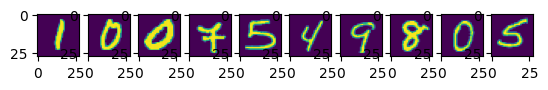

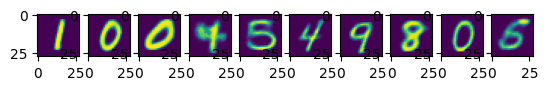

In [97]:
aae_encoder.eval()
aae_decoder.eval()
predictions = []
plots = 10
for i, data in enumerate(test_dataset):
    if i == plots:
        break
    pred = aae_decoder(aae_encoder(data[0].to(device).unsqueeze(0).view(1, 784)))
    predictions.append(pred.view(1, 28, 28).detach().cpu())
plotn(plots, test_dataset)
plotn(plots, predictions)

## Additional Materials

* [Blog post on NeuroHive](https://neurohive.io/ru/osnovy-data-science/variacionnyj-avtojenkoder-vae/)
* [Variational Autoencoders Explained](https://kvfrans.com/variational-autoencoders-explained/)